In [1]:
import sys
sys.path.append("..")

In [43]:
import importlib
import dccs
import dccs.math.camera_model
import dccs.math.algebra as dm
from dccs.math.extrinsic import Transformation
from dccs.math.algebra import quaternion_to_angles
importlib.reload(dccs.math.camera_model)
from dccs.math.camera_model import CameraData
#from dccs.math.odometry import SlamOdometry
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
plt.rcParams['figure.figsize'] = [9, 7]
plt.rcParams['savefig.bbox'] = 'tight'
plt.rcParams['savefig.pad_inches'] = 0.1
plt.rcParams['savefig.dpi'] = 300
%matplotlib notebook

In [44]:
def load_logs_set(camera_data, suffix):
    full_logs = [f for f in camera_data.list_dir("logs") if f.startswith("full") and f.endswith(suffix)]
    assert len(full_logs) == 1
    full_log = full_logs[0]
    time = full_log[len("full_positions_log"):]
    pose_log = [f for f in camera_data.list_dir("logs") if f.startswith("positions") and f.endswith(time)][0]
    estimations_log = [f for f in camera_data.list_dir("logs") if f.startswith("estimations") and f.endswith(time)][0]
    return time, full_log, pose_log, estimations_log

In [45]:
working_dir = "/home/drv/pCloudDrive/magisterka/"
cameras = [CameraData("360/"+str(i)) for i in range(3)]

# Ground truth
In following example ground truth was based on printed camera rig paramters. They are following:

In [46]:
pos = ["x", "y", "z"]
ang = ["p", "q", "r"]
quat = ["qx", "qy", "qz", "qw"]
def v(pos):
    return ["v"+p for p in pos]
def e(pos):
    return ["e"+p for p in pos]
def r(pos):
    return ["r"+p for p in pos]
full_log_entry_len = 26

def quat_to_angle(row):
    q = quaternion_to_angles(np.array(row[quat])) # radians
    # q = q * 180 / np.pi # degrees
    row[r(ang)[0]] = q[0]
    row[r(ang)[1]] = q[1] 
    row[r(ang)[2]] = q[2]
    return row


def load_pose_log(camera_data, file_name):
    pose_entries = [l.strip().split(";") for l in camera_data.get_file("logs", file_name, "r").readlines()]
    parsed = []
    for entry in pose_entries:
        if entry[1].strip() != "None":
            parsed.append((entry[0], [float(i) for i in entry[1].split(",")],  float(entry[-1].strip())))
        else:
            parsed.append((entry[0], None, None))
    return parsed

def load_full_log(camera_data, file_name):
    log_array = np.frombuffer(camera_data.get_file("logs", file_name, "rb").read()).reshape((-1, full_log_entry_len))
    log_pd = pd.DataFrame(log_array, columns=['t'] + pos + v(pos) + ang + v(ang) + e(pos) + e(ang) + r(pos) + quat)
    return log_pd.apply(quat_to_angle, axis=1)

def load_est_log(camera_data, file_name):
    est_entries = [l.strip().split(";") for l in camera_data.get_file("logs", file_name).readlines()]
    parsed = []
    for entry in est_entries:
        t_arr = np.array([float(f) for f in entry[1].split(",")])
        if len(t_arr) == 6:
            t = Transformation.from_inlined(t_arr)
        elif len(t_arr) == 8:
            t = Transformation.from_inlined_full(t_arr)
        else:
            raise ValueError("Incorrect estimation: " + entry[1])
        parsed.append((entry[0], t))
    return parsed

In [47]:
sorted([x+"_"+str(i) for i in range(0,3) for x in cameras[i].list_dir("logs") if x.startswith("full")])

['full_positions_log20190311_0906_0',
 'full_positions_log20190311_0916_0',
 'full_positions_log20190311_0918_0',
 'full_positions_log20190311_0929_0',
 'full_positions_log20190311_1440_0',
 'full_positions_log20190501_2223_1',
 'full_positions_log20190501_2223_2',
 'full_positions_log20190501_2236_1',
 'full_positions_log20190501_2236_2',
 'full_positions_log20190501_2245_1',
 'full_positions_log20190501_2245_2',
 'full_positions_log20190501_2247_1',
 'full_positions_log20190501_2247_2',
 'full_positions_log20190501_2258_1',
 'full_positions_log20190501_2258_2',
 'full_positions_log20190501_2309_1',
 'full_positions_log20190501_2309_2',
 'full_positions_log20190501_2310_0',
 'full_positions_log20190501_2313_1',
 'full_positions_log20190501_2313_2',
 'full_positions_log20190501_2314_0',
 'full_positions_log20190501_2334_1',
 'full_positions_log20190501_2334_2',
 'full_positions_log20190501_2336_0',
 'full_positions_log20190502_0908_1',
 'full_positions_log20190502_0908_2',
 'full_posit

In [48]:
times = []
full_files = []
pose_files = []
est_files = []
poses = []
full = []
est = []

for suffix, camera in zip(["_1633", "_1632", "_1632"], cameras):
    vals = load_logs_set(camera, suffix)
    times.append(vals[0])
    full_files.append(vals[1])
    full.append(load_full_log(camera, vals[1]))
    pose_files.append(vals[2])
    poses.append(load_pose_log(camera, vals[2]))
    est_files.append(vals[3])
    est.append(load_est_log(camera, vals[3]))
    
    
if all([len(e) == 0 for e in est]):
    print("ERROR! No estimated poses!")

In [49]:
#detect gaps
def breaks_df(df, cols):
    gaps = df.t.diff(-1) < -1
    return pd.DataFrame({"t": df.t[gaps], "dt": -df.t.diff(-1)[gaps]})
    

gaps = [(f.t.diff(1) > 1).replace({False: None, True: 1.0}) for f in full]
for f, g in zip(full, gaps):
    f["cont"] = g

# Charts
## Position log with synchronization points (raw)

In [50]:
markersize=8
tshift = 1557066850
tlength = 150

def plot_msg_point(ax, point, t, marker):
    if t == None or point == None:
        return
    ax.scatter([t,t,t], point[:3], c=['b', 'r', 'g'], s=markersize, marker=marker)

def plot_breaks(ax, ts, dts):
    bottom, top = ax.get_ylim()
    ax.bar(ts, len(ts) * [top-bottom], bottom=len(ts)* [bottom], alpha=0.2,
           color='red', width=dts.to_numpy(), align='edge')
    ax.set_ylim(bottom, top)

fig, axes = plt.subplots(nrows=len(full), sharex=True)
breaks = [breaks_df(f[["t"] + r(pos)], r(pos)) for f in full]

for i,ax in enumerate(axes):
  ax.set_xlim([0, tlength])
  ax.set(ylabel="360/"+str(i))

for a,b,f in zip(axes, breaks, full):
  for coord in pos:  
    a.plot(f["t"]-tshift, f["r"+coord], label=coord)
  plot_breaks(a, b.t-tshift, b.dt)
for a,p in zip (axes, poses):
    for entry in p:
        #print(entry)
        idx = int(entry[0][-1])
        for i, a2 in enumerate(axes):
            if idx == i and entry[2] is not None:
                plot_msg_point(a2, entry[1], entry[2]-tshift, "x")
            else:
                pass
                #plot_msg_point(a2, entry[1], entry[2], "x")
for ax in axes:                
  ax.legend(loc="lower left")
fig.savefig(working_dir+"360_full_pose.png")


<IPython.core.display.Javascript object>

## Orientation log with synchronization points

In [51]:
def plot_orientation_point(ax, point, t, marker):
    if t == None or point == None:
        return
    ax.scatter([t,t,t], quaternion_to_angles(np.array(point[3:])), c=['b', 'r', 'g'], s=markersize, marker=marker)

fig, axes = plt.subplots(nrows=len(full), sharex=True)
breaks = [breaks_df(f[["t"] + r(pos)], r(pos)) for f in full]

for i,ax in enumerate(axes):
  ax.set_xlim([0, tlength])
  ax.set(ylabel="360/"+str(i))

for a,b,f in zip(axes, breaks, full):
  for coord,name in zip(ang, ["x", "y", "z"]):
    a.plot(f["t"]-tshift, f["r" + coord], label="σ"+name)
  plot_breaks(a, b.t-tshift, b.dt)
    
for a,p in zip (axes, poses):
    for entry in p:
        #print(entry)
        idx = int(entry[0][-1])
        for i, a2 in enumerate(axes):
            if idx == i and entry[2] is not None:
                plot_orientation_point(a2, entry[1], entry[2]-tshift, "x")
            else:
                pass
                #plot_msg_point(a2, entry[1], entry[2], "x")
for ax in axes:                
  ax.legend(loc="lower left")
fig.savefig(working_dir+"360_full_orientation.png")

<IPython.core.display.Javascript object>

# Analyze result estimations

Result poses in est_ are describing tranformation between camera origins. Note, that recorded poses (full_ ) are registered in arbitrary odom frame, not in camera frame - so it cannot be simply mapped with discovered transformation. They have to be merged with some common point - here let it be first registered pose.

In [52]:
poses[1]

[('360/2',
  [0.21866391599178314,
   -0.024339132010936737,
   0.13711422681808472,
   0.0033185759001796294,
   0.06901005636433873,
   -0.03671866272661627,
   0.9969344707563054],
  1557066775.2325943),
 ('360/1',
  [-0.06867936173399689,
   0.010641480896806985,
   -0.041624378018323936,
   0.01843498113563543,
   0.1306805971981919,
   0.0788333562010089,
   0.9881133714997169],
  1557066775.2325943),
 ('360/2',
  [0.2172013372182846,
   -0.015148532576858997,
   0.10844387114048004,
   -0.020708241656366977,
   0.07175389408778357,
   -0.03182488560795049,
   0.9966994151030597],
  1557066775.792854),
 ('360/1',
  [-0.08503652440233528,
   0.017905963715952884,
   -0.016914250974642116,
   0.031913724877562666,
   0.13104758482321174,
   0.09796677558380316,
   0.9860073810870561],
  1557066775.792854),
 ('360/2',
  [0.20655997097492218,
   0.007163576316088438,
   0.0465642549097538,
   -0.04347798853171626,
   0.058953574160761774,
   -0.022354553767184555,
   0.99706289397047

In [53]:
def find_first_poses_pair(poses, cam_1, cam_2):
    for poses_idx in range(0, len(poses), 2):
        p1 = poses[poses_idx]
        p2 = poses[poses_idx+1]
        if p1[1] != None and p2[1] != None:
          if p1[0] == cam_1 and p2[0] == cam_2:
            print(f"Selected idx {poses_idx} for camera {p1[0]} {p2[0]}")
            return [Transformation.from_inlined_quaternion(np.array(x[1])) for x in poses[poses_idx:poses_idx+2]]

In [54]:
common_pose_1, common_pose_0 = find_first_poses_pair(poses[0], "360/1", "360/0")
print(common_pose_0)
print(common_pose_1)
def from_1_to_0(pose_1):
    return Transformation.from_inlined(pose_1).substract(common_pose_1
                                                     ).around(t_0_1).substract(common_pose_0.inverse()).inline
log_1_in_0_coords = full[1][r(pos + ang)].T.transform(from_1_to_0).T

fig, (ax_pos, ax_ang) = plt.subplots(nrows=2)
colors = ["#003f5c", "#bc5090","#ffa600"]

xlimits = [1557066850,1557066950]
ax_ang.set_xlim([0,150])
ax_ang.set(ylabel="angle(rad)")
ax_pos.set_xlim([0,150])
ax_pos.set(ylabel="position")
tshift = xlimits[0]
for i,name in enumerate(["x", "y", "z"]):
    #plot originaldata
    ax_ang.plot(full[0]["t"]-tshift, full[0][r(ang)[i]], color=colors[i], label="σ"+name)
    #and those reprojected
    ax_ang.plot(full[1]["t"]-tshift, log_1_in_0_coords[r(ang)[i]], "--", color=colors[i])

    ax_pos.plot(full[0]["t"]-tshift, full[0][r(pos)[i]], color=colors[i], label=name)
    ax_pos.plot(full[1]["t"]-tshift, log_1_in_0_coords[r(pos)[i]], "--", color=colors[i])
    
plot_breaks(ax_pos, breaks[0].t-tshift, breaks[0].dt)
plot_breaks(ax_pos, breaks[1].t-tshift, breaks[1].dt)
plot_breaks(ax_ang, breaks[0].t-tshift, breaks[0].dt)
plot_breaks(ax_ang, breaks[1].t-tshift, breaks[1].dt)

ax_pos.legend(loc='lower left')
ax_ang.legend(loc='lower left')
plt.plot()
fig.savefig(working_dir + "transformed_test_0_to_1.png")

Selected idx 12 for camera 360/1 360/0
Transformation{ shift:[ 0.083   0.0184 -0.0005], rot:[-0.0507 -0.1293 -0.0619], scale: 1.0}
Transformation{ shift:[0.1119 0.01   0.062 ], rot:[ 0.2437  0.402  -0.1052], scale: 1.0}


<IPython.core.display.Javascript object>

In [60]:
def plot_reprojection(base_idx, projected_idx, transformation):
  common_pose_2, common_pose_0 = find_first_poses_pair(poses[0], "360/" + str(projected_idx), "360/" + str(base_idx))
  print(common_pose_0)
  print(common_pose_2)
  def from_2_to_0(pose_2):
      return Transformation.from_inlined(pose_2).substract(common_pose_2
                                                       ).around(transformation).substract(common_pose_0.inverse()).inline
  log_projected = full[projected_idx][r(pos + ang)].T.transform(from_2_to_0).T

  fig, (ax_pos, ax_ang) = plt.subplots(nrows=2, sharex=True)
  colors = ["#003f5c", "#bc5090","#ffa600"]

  xlimits = [1557066850,1557066950]
  ax_ang.set_xlim([0,150])
  ax_ang.set(ylabel="angle(rad)")
  ax_pos.set_xlim([0,150])
  ax_pos.set(ylabel="position")
  tshift = xlimits[0]
  for i,name in enumerate(["x", "y", "z"]):
      #plot originaldata
      ax_ang.plot(full[base_idx]["t"]-tshift, full[base_idx][r(ang)[i]], color=colors[i], label="σ"+name)
      #and those reprojected
      ax_ang.plot(full[projected_idx]["t"]-tshift, log_projected[r(ang)[i]], "--", color=colors[i])

      ax_pos.plot(full[base_idx]["t"]-tshift, full[base_idx][r(pos)[i]], color=colors[i], label=name)
      ax_pos.plot(full[projected_idx]["t"]-tshift, log_projected[r(pos)[i]], "--", color=colors[i])

  plot_breaks(ax_pos, breaks[base_idx].t-tshift, breaks[base_idx].dt)
  plot_breaks(ax_pos, breaks[projected_idx].t-tshift, breaks[projected_idx].dt)
  plot_breaks(ax_ang, breaks[base_idx].t-tshift, breaks[base_idx].dt)
  plot_breaks(ax_ang, breaks[projected_idx].t-tshift, breaks[projected_idx].dt)

  ax_pos.legend(loc='lower left')
  ax_ang.legend(loc='lower left')
  plt.plot()
  fig.savefig(working_dir + "transformed_test_" + str(projected_idx) + "_to_" + str(base_idx) +".png")

Selected idx 12 for camera 360/1 360/0
Transformation{ shift:[ 0.083   0.0184 -0.0005], rot:[-0.0507 -0.1293 -0.0619], scale: 1.0}
Transformation{ shift:[0.1119 0.01   0.062 ], rot:[ 0.2437  0.402  -0.1052], scale: 1.0}


<IPython.core.display.Javascript object>


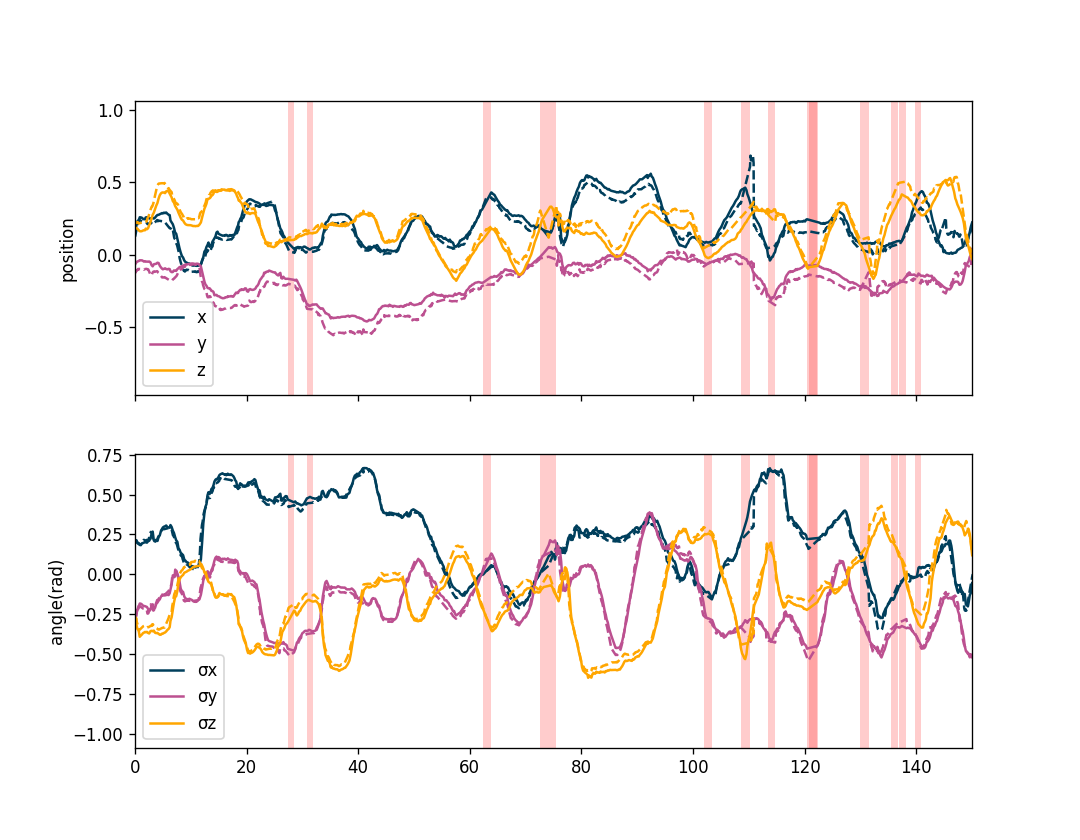

In [62]:
plot_reprojection(0, 1, t_1_0.inverse())

In [57]:
plot_reprojection(0, 2, t_0_2)

Selected idx 14 for camera 360/2 360/0
Transformation{ shift:[ 0.1331  0.0172 -0.0022], rot:[-0.0632 -0.1038 -0.1068], scale: 1.0}
Transformation{ shift:[-0.0971  0.0266  0.2766], rot:[0.2096 0.2704 0.2605], scale: 1.0}


<IPython.core.display.Javascript object>

In [58]:
# plot raw data from camera stereo/askew and vision of this movement from another camera
#t_s.scale = 1.085
print(t_s)

def from_1_to_0(pose_1):
    return Transformation.from_inlined(pose_1).substract(cpose_s
                                                     ).around(t_s.inverse()).substract(cpose_a.inverse()).inline
    #return Transformation.from_inlined(s_pose).around(t_s.inverse()).inline
log_a_from_s = full_s[r(pos + ang)].T.transform(s2a).T

fig, (ax_pos, ax_ang) = plt.subplots(nrows=2)
colors = ["#003f5c", "#58508d","#bc5090","#ff6361","#ffa600"]
for i in range(3):
    ax_ang.plot(full_a["t"], full_a[r(ang)[i]], color=colors[i])
    ax_ang.plot(full_s["t"], log_a_from_s[r(ang)[i]], "--", color=colors[i])

    ax_pos.plot(full_a["t"], full_a[r(pos)[i]], color=colors[i])
    ax_pos.plot(full_s["t"], log_a_from_s[r(pos)[i]], "--", color=colors[i])
plot_breaks(ax_pos, breaks_a.t, breaks_a.dt)
plot_breaks(ax_pos, breaks_s.t, breaks_s.dt)
plot_breaks(ax_ang, breaks_a.t, breaks_a.dt)
plot_breaks(ax_ang, breaks_s.t, breaks_s.dt)

plt.plot()
fig.savefig(working_dir + "transformed_test_s2a.png")

NameError: name 't_s' is not defined

In [ ]:
trimmed_s = pd.DataFrame(full_s[r(pos+ang)])
trimmed_a = pd.DataFrame(full_a[r(pos+ang)])
idx_a = pd.to_datetime(full_a["t"], unit='s')
idx_s = pd.to_datetime(full_s["t"], unit='s')

new_a = trimmed_a.set_index(idx_a)
new_s = trimmed_s.set_index(idx_s)
oidx_a = new_a.index
oidx_s = new_s.index
nidx_a = pd.date_range(oidx_a.min(), oidx_a.max(), freq='s').round('s')
nidx_s = pd.date_range(oidx_s.min(), oidx_s.max(), freq='s').round('s')

resampled_a = new_a.reindex(oidx_a.union(nidx_a)).interpolate('time').reindex(nidx_a)
resampled_s = new_s.reindex(oidx_s.union(nidx_s)).interpolate('time').reindex(nidx_s)
"""
new_straight_in_askew = pd.DataFrame(log_straight_in_askew[pos+ang]).set_index(pd.to_datetime(log_straight["t"], unit='s'))
oidx = new_straight_in_askew.index
nidx = pd.date_range(oidx.min(), oidx.max(), freq='s').round('s')
resampled_straight_in_askew = new_straight_in_askew.reindex(oidx.union(nidx)).interpolate().reindex(nidx)
"""
common_idx = resampled_a.index.intersection(resampled_s.index)


diff = resampled_a.reindex(common_idx) - resampled_s.reindex(common_idx).T.transform(s2a).T
#trimmed_s.plot()
#resampled_s.plot()

In [ ]:
diff_timestamps = diff.index.astype(np.int64) // 10**9
#import itertools.
from itertools import chain

def isgood(val):
    for bt, bdt in chain(zip(breaks_s.t, breaks_s.dt), zip(breaks_a.t, breaks_a.dt)):
        if bt + bdt >= val:
            if bt <= val:
                return False
            else:
                break
    return True

diff_mask = [isgood(t) for t in diff_timestamps]
diff2 = diff[diff_mask]

fig, axs = plt.subplots()
axs.plot(diff_timestamps[diff_mask], diff2)
axs.legend(diff2)

# plt.plot(pd.to_datetime(breaks_a.t)))
plot_breaks(axs, breaks_s.t, breaks_s.dt)
plot_breaks(axs, breaks_a.t, breaks_a.dt)
#diff[pos].plot()
plt.show()
fig.savefig(working_dir + "stereo_error_plot.png")

In [ ]:
import dccs.math.algebra as dm

def normalize_pos(row):
    row[pos] = dm.normalized_l2(row[pos])
    return row

print("360/0 ->")
print("\n".join(map(str,est[0])))

print("360/1 ->")
print("\n".join(map(str,est[1])))

print("360/2 ->")
print("\n".join(map(str,est[2])))

In [22]:
t_0_1 = list(filter(lambda x: x[0]=='360/1', est[0]))[-1][1]
t_0_2 = list(filter(lambda x: x[0]=='360/2', est[0]))[-1][1]
t_1_0 = list(filter(lambda x: x[0]=='360/0', est[1]))[-1][1]
t_1_2 = list(filter(lambda x: x[0]=='360/2', est[1]))[-1][1]
t_2_0 = list(filter(lambda x: x[0]=='360/0', est[2]))[-1][1]
t_2_1 = list(filter(lambda x: x[0]=='360/1', est[2]))[-1][1]

In [23]:
print(t_0_1.append(t_1_0))
print(t_2_1.append(t_1_2))
print(t_0_2.append(t_2_0))

Transformation{ shift:[-0.03265305 -0.04326747  0.01297697], rot:[ 0.01108537 -0.01618825  0.00678673], scale: 0.8758750919719607}
Transformation{ shift:[ 0.02881469 -0.05074012  0.04020245], rot:[-0.00790162 -0.10101654 -0.168989  ], scale: 0.7627749969002876}
Transformation{ shift:[-0.01487461 -0.10524057  0.00366031], rot:[-0.01150149 -0.01777477  0.0162097 ], scale: 0.9015469732744279}


In [24]:
print(t_0_1.append(t_1_0))
print(t_2_1.append(t_1_2))
print(t_0_2.append(t_2_0))

Transformation{ shift:[-0.03265305 -0.04326747  0.01297697], rot:[ 0.01108537 -0.01618825  0.00678673], scale: 0.8758750919719607}
Transformation{ shift:[ 0.02881469 -0.05074012  0.04020245], rot:[-0.00790162 -0.10101654 -0.168989  ], scale: 0.7627749969002876}
Transformation{ shift:[-0.01487461 -0.10524057  0.00366031], rot:[-0.01150149 -0.01777477  0.0162097 ], scale: 0.9015469732744279}


In [25]:
print(t_0_1, t_1_2, t_2_0)
t_0_1.append(t_1_2).append(t_2_0)

Transformation{ shift:[-0.03084778 -0.00985621 -0.00800148], rot:[3.12428492 1.06351295 3.11984741], scale: 2.2873032598963676} Transformation{ shift:[ 0.01282107 -0.04646723  0.02348269], rot:[-3.04430047  1.14715446 -3.10809409], scale: 0.30120390167626626} Transformation{ shift:[ 0.08297088  0.06078723 -0.06130937], rot:[-3.04722393  0.96588923 -3.00993013], scale: 1.3959565809197627}


Transformation{ shift:[0.02720085 0.00920611 0.14741115], rot:[-0.07499934 -0.03273078  0.13147183], scale: 0.9617368406681492}

In [26]:
print(t_2_1, t_1_0, t_0_2)
t_2_1.append(t_1_0).append(t_0_2)

Transformation{ shift:[-0.04876222  0.03010312 -0.23748223], rot:[ 2.96036037 -1.03998324 -2.90864593], scale: 2.5324207045635068} Transformation{ shift:[ 0.01590045 -0.03863614 -0.03288624], rot:[ 3.12247394 -1.04744529 -3.12865623], scale: 0.38292914950492596} Transformation{ shift:[-0.06148249 -0.11693351  0.04249637], rot:[ 3.12882989 -0.95118682 -3.07500828], scale: 0.6458273742872573}


Transformation{ shift:[ 0.1326923  -0.13903096  0.04311908], rot:[ 0.03605881 -0.08987261 -0.05196755], scale: 0.6262831567925381}

In [27]:
np.set_printoptions(precision=4)

In [28]:
def analyze(a_to_b, b_to_a):
  avg = Transformation.average_transformation([a_to_b, b_to_a.inverse()])
  print(a_to_b)
  print(avg)
  print(b_to_a.inverse())
  print("="*20)
  print(a_to_b.norm.pure_translation)
  print(dm.normalized_l2(avg.pure_translation))
  print(b_to_a.norm.pure_translation)
  print("="*20)
  print(a_to_b.norm.translation)
  print(dm.normalized_l2(np.array(avg.translation)))
  print(b_to_a.inverse().norm.translation)
  print("-"*20)
  print(dm.l2_norm(a_to_b.pure_translation))
  print(dm.l2_norm(avg.pure_translation))
  print(dm.l2_norm(b_to_a.inverse().pure_translation))

In [29]:
pt_0_1 = Transformation.average_transformation([t_0_1, t_1_0.inverse()])
analyze(t_0_1, t_1_0)

Transformation{ shift:[-0.0308 -0.0099 -0.008 ], rot:[3.1243 1.0635 3.1198], scale: 2.2873032598963676}
Transformation{ shift:[-0.0362  0.0455  0.0389], rot:[3.1251 1.0555 3.1272], scale: 2.449376202356501}
Transformation{ shift:[-0.0416  0.1009  0.0858], rot:[3.1258 1.0475 3.1343], scale: 2.611449144816634}
[-0.9248 -0.2955 -0.2399]
[-0.5175  0.6503  0.5561]
[ 0.299  -0.7266 -0.6185]
[ 0.6557 -0.3036 -0.6913]
[-0.2242  0.6548 -0.7218]
[-0.3832  0.7334 -0.5615]
--------------------
0.03335797066487245
0.06999335148079316
0.1388515336906487


In [30]:
pt_1_2 = Transformation.average_transformation([t_1_2, t_2_1.inverse()])
analyze(t_1_2, t_2_1)

Transformation{ shift:[ 0.0128 -0.0465  0.0235], rot:[-3.0443  1.1472 -3.1081], scale: 0.30120390167626626}
Transformation{ shift:[ 0.0158 -0.0292  0.0587], rot:[-3.0706  1.0977 -3.0471], scale: 0.34804149913237314}
Transformation{ shift:[ 0.0189 -0.0119  0.0939], rot:[-3.1006  1.0491 -2.9889], scale: 0.3948790965884801}
[ 0.2391 -0.8666  0.438 ]
[ 0.235  -0.433   0.8702]
[-0.1996  0.1232 -0.9721]
[-0.4855 -0.8689  0.0962]
[-0.8626 -0.468  -0.1919]
[-0.9304 -0.1654 -0.3271]
--------------------
0.05361921072581035
0.06741644195315827
0.09646837615908248


In [31]:
pt_2_0 = Transformation.average_transformation([t_2_0, t_0_2.inverse()])
analyze(t_2_0, t_0_2)

Transformation{ shift:[ 0.083   0.0608 -0.0613], rot:[-3.0472  0.9659 -3.0099], scale: 1.3959565809197627}
Transformation{ shift:[ 0.0779  0.1204 -0.0765], rot:[-3.059   0.9577 -3.0276], scale: 1.472178982327125}
Transformation{ shift:[ 0.0729  0.1801 -0.0918], rot:[-3.0704  0.9494 -3.045 ], scale: 1.5484013837344874}
[ 0.6929  0.5077 -0.512 ]
[ 0.4792  0.7408 -0.4708]
[-0.443  -0.8426  0.3062]
[-0.0074  0.4963  0.8681]
[0.0626 0.7393 0.6705]
[0.1037 0.8414 0.5303]
--------------------
0.11974177877956095
0.16260295887084036
0.2148848826858922


In [32]:
print("\n".join(map(str, [pt_0_1, pt_1_2, pt_2_0])))
print(pt_0_1.append(pt_1_2).append(pt_2_0))
dm.l2_norm(t_0_1.append(t_2_0).append(t_1_2).translation)

Transformation{ shift:[-0.0362  0.0455  0.0389], rot:[3.1251 1.0555 3.1272], scale: 2.449376202356501}
Transformation{ shift:[ 0.0158 -0.0292  0.0587], rot:[-3.0706  1.0977 -3.0471], scale: 0.34804149913237314}
Transformation{ shift:[ 0.0779  0.1204 -0.0765], rot:[-3.059   0.9577 -3.0276], scale: 1.472178982327125}
Transformation{ shift:[0.0697 0.1101 0.1943], rot:[-0.0071  0.0277  0.0619], scale: 1.255009859950923}


0.03653311122776571

In [33]:
print(dm.normalized_l2(np.array((pt_0_1.pure_translation))))
print(dm.normalized_l2(np.array((pt_1_2.pure_translation))))
print(dm.normalized_l2(np.array((pt_2_0.pure_translation))))
rm = dm.rotation_angles_to_mtx([np.pi, np.pi/3, np.pi])
shift = np.array([np.sqrt(3)/2, -0.5, 0])
print(dm.normalized_l2(np.array((Transformation(np.linalg.inv(rm).dot(shift), rm.dot(rm)).translation))))
print(dm.normalized_l2(np.array((Transformation(np.linalg.inv(rm).dot(shift), rm).translation))))
print(dm.normalized_l2(np.array((Transformation(np.linalg.inv(rm).dot(shift), rm.dot(rm)).pure_translation))))
print(dm.normalized_l2(np.array((Transformation(np.linalg.inv(rm).dot(shift), rm).pure_translation))))

[-0.5175  0.6503  0.5561]
[ 0.235  -0.433   0.8702]
[ 0.4792  0.7408 -0.4708]
[-0.433 -0.5    0.75 ]
[-0.433 -0.5    0.75 ]
[-0.433 -0.5   -0.75 ]
[ 8.6603e-01 -5.0000e-01  1.1102e-16]


In [34]:
print("[" + ",".join(map(lambda x: str(round(x, 4)), t_0_1.translation)) + "]")
print("[" + ",".join(map(lambda x: str(round(x, 4)), t_1_0.pure_translation)) + "]")
print("[" + ",".join(map(lambda x: str(round(x, 4)), t_1_0.inverse().pure_translation * t_1_0.scale)) + "]")
print("[" + ",".join(map(lambda x: str(round(x, 4)), pt_0_1.translation)) + "]")
print("[" + ",".join(map(lambda x: str(round(x, 4)), pt_1_2.translation)) + "]")
print("[" + ",".join(map(lambda x: str(round(x, 4)), pt_2_0.translation)) + "]")

[0.0219,-0.0101,-0.0231]
[0.0159,-0.0386,-0.0329]
[-0.0159,0.0386,0.0329]
[-0.0157,0.0458,-0.0505]
[-0.0582,-0.0316,-0.0129]
[0.0102,0.1202,0.109]


In [35]:
print("[" + ",".join(map(lambda x: str(round(x, 4)), t_0_1.angles)) + "]")
print("[" + ",".join(map(lambda x: str(round(x, 4)), t_1_0.angles)) + "]")
print("[" + ",".join(map(lambda x: str(round(x, 4)), t_0_2.angles)) + "]")
print("[" + ",".join(map(lambda x: str(round(x, 4)), t_2_0.angles)) + "]")
print("[" + ",".join(map(lambda x: str(round(x, 4)), t_1_2.angles)) + "]")
print("[" + ",".join(map(lambda x: str(round(x, 4)), t_2_1.angles)) + "]")

[3.1243,1.0635,3.1198]
[3.1225,-1.0474,-3.1287]
[3.1288,-0.9512,-3.075]
[-3.0472,0.9659,-3.0099]
[-3.0443,1.1472,-3.1081]
[2.9604,-1.04,-2.9086]


In [36]:
import dccs.math.algebra as dm

def normalize_pos(row):
    row[pos] = dm.normalized_l2(row[pos])
    return row

print("360/0 ->")
print("\n".join(map(str,est[0])))

print("360/1 ->")
print("\n".join(map(str,est[1])))

print("360/2 ->")
print("\n".join(map(str,est[2])))

360/0 ->
('360/2', Transformation{ shift:[-0.0764 -0.1602  0.0714], rot:[-3.0162 -0.9703  3.0715], scale: 0.6439069372548355})
('360/1', Transformation{ shift:[-0.0716 -0.0022 -0.087 ], rot:[3.0435 1.046  3.0684], scale: 2.043468225640442})
('360/2', Transformation{ shift:[-0.0777 -0.1068  0.1317], rot:[-3.0111 -0.9602  3.0497], scale: 0.636389121938794})
('360/2', Transformation{ shift:[-0.0959 -0.077   0.1056], rot:[-3.0792 -0.9602  3.099 ], scale: 0.6532163104103108})
('360/1', Transformation{ shift:[-0.0755 -0.0328 -0.0695], rot:[3.0278 1.0389 3.0595], scale: 2.0241001911478085})
('360/2', Transformation{ shift:[-0.096  -0.1012  0.1025], rot:[-3.0985 -0.9427  3.1196], scale: 0.6484734218631306})
('360/2', Transformation{ shift:[-0.0871 -0.1074  0.1147], rot:[-3.0863 -0.9613  3.0881], scale: 0.641662466937823})
('360/2', Transformation{ shift:[-0.0779 -0.1222  0.1068], rot:[-3.0945 -0.9613  3.1192], scale: 0.6313563205847431})
('360/1', Transformation{ shift:[-0.0791 -0.0418 -0.0575

In [ ]:
tp_0_1 = est[0][-2][1]
tp_0_2 = est[0][-1][1]
tp_1_0 = est[1][-4][1]
tp_1_2 = est[1][-1][1]
tp_2_0 = est[2][-3][1]
tp_2_1 = est[2][-1][1]

In [ ]:
print(tp_1_2, "\n", t_1_2)

In [ ]:
0.27985933 / 3.14 * 180

In [ ]:
import cv2
image0 = cv2.imread("/home/drv/tmp/cyl.png")
image1 = cv2.imread("/home/drv/tmp/cyl1.png")
image2 = cv2.imread("/home/drv/tmp/cyl2.png")

In [ ]:
shift1 = pt_0_1.ang

In [ ]:
cx0, cy0, f0 = 794.54016, 558.66785, 0.31142565504579073
cx1, cy1, f1 = 933.3144, 506.50958, 0.32906002
cx2, cy2, f2 = 858.1688, 559.9293, 0.34326409426725135
mx1 = max(cx1, 1857-cx1)


In [ ]:
from pyrr.quaternion import apply_to_vector

In [ ]:
shift1 = apply_to_vector(quat=pt_0_1.quaternion, vec=[0, 0, f1])

In [ ]:
x,y,z = shift1
s = 1 / 1.5

In [ ]:
xp = z * np.tan(x/s)
yp = z * y / s / np.cos(x / s)

In [ ]:
xp, yp

In [ ]:
shift1

In [100]:
pt_0_1.quaternion

Quaternion([0.0020814 , 0.86392116, 0.00349449, 0.50361065])

In [109]:
xp-np.pi/2

-1.6450595751846298

In [112]:
def xproj(x):
    return f0 * np.tan(x / s)
xproj(-xp-np.pi/2)

0.24876399950243358

In [116]:
794/0.807622591879535*(-xp-np.pi/2)
#-> środek przesunięty o 

-1471.2902737011827

In [115]:
cx1 + 1617 - cx0

1755.7742400000002